# Pipeline 2 - Pruebas

In [45]:
import os, sys
sys.path.append(os.path.abspath("../"))
from utils.toolbox import *

import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [46]:
# Se lee el dataset de trabajo
df = pd.read_csv("../data/Datos_Reservas_full.csv")

# Se extrae una muestra aleatoria de mil registros y se guarda el archivo, con y sin target
df_muestra = df.sample(1000, random_state = 42)
df_muestra.to_csv("../data_sample/muestra_reservas.csv", index = False) 
df_muestra_x = df_muestra.drop(columns = ["canceled"])
df_muestra_x.to_csv("../data_sample/muestra_reservas_sin_target.csv", index = False) 

# Se eliminan esos registros del dataset original
df = df[~df.isin(df_muestra).all(axis=1)]

In [47]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)
target = "canceled"

In [48]:
# Se forman los subconjuntos X,y
X_train = train_set.copy()
X_train.drop(columns = [target], inplace = True)
y_train = train_set[target].copy()

X_test = test_set.copy()
X_test.drop(columns = [target], inplace = True)
y_test = test_set[target].copy()

In [49]:
# Procesado a través de pipeline
processor = FunctionTransformer(total_transform)

# Se añade el modelo con los ajustes establecidos previamente
pipeline_RFC = Pipeline(
    [("Procesado", processor),
     ("Classifier", RandomForestClassifier(criterion = "log_loss", n_estimators = 290, max_depth = 30, min_samples_split = 2, min_samples_leaf = 1, max_features = None, class_weight = "balanced", random_state = 42))])

pipeline_RFC

Pipeline(steps=[('Procesado',
                 FunctionTransformer(func=<function total_transform at 0x000001A67EC54540>)),
                ('Classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='log_loss', max_depth=30,
                                        max_features=None, n_estimators=290,
                                        random_state=42))])

In [50]:
pipeline_RFC.fit(X_train, y_train)

Pipeline(steps=[('Procesado',
                 FunctionTransformer(func=<function total_transform at 0x000001A67EC54540>)),
                ('Classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='log_loss', max_depth=30,
                                        max_features=None, n_estimators=290,
                                        random_state=42))])

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     19474
           1       0.81      0.78      0.80     10997

    accuracy                           0.86     30471
   macro avg       0.85      0.84      0.84     30471
weighted avg       0.86      0.86      0.86     30471



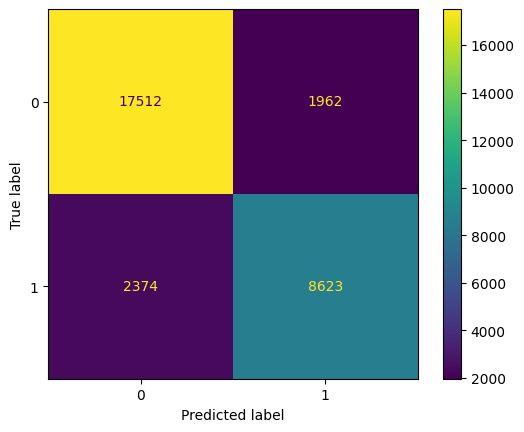

In [51]:
# Evaluación
y_pred_pipeline = pipeline_RFC.predict(X_test)
print(classification_report(y_test, y_pred_pipeline))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pipeline);

In [ ]:
df_test = pd.read_csv("../data_sample/muestra_reservas_sin_target.csv")
df_test_sol = pd.read_csv("../data_sample/muestra_reservas.csv")

In [56]:
df_predict = pipeline_RFC.predict(df_test)
df_predict

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,

In [58]:
(df_test_sol.canceled == df_predict).value_counts()

canceled
True     848
False    152
Name: count, dtype: int64

In [43]:
# Se guarda el modelo con pickle:
with open("../models/model_pl_RF.pkl", "wb") as archivo:
    pickle.dump(pipeline_RFC, archivo)